# 获取数据集

In [94]:
from torchvision import transforms,datasets,models
import torch
from torch.utils import data
import matplotlib.pyplot as plt
from dltool import dataprocess,train
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F

In [122]:
def load_data_mnist(batch_size, resize=None):
    """下载数据集并加载到内存中"""
    # 将图像从PIL类型转换为32位浮点数格式并/255，使得像素在0~1之间
    trans = [transforms.ToTensor()]
    if resize is not None:
        trans.insert(0,transforms.Resize((resize,resize)))
    trans = transforms.Compose(trans)
    mnist_train = datasets.MNIST(
        root="../data", train=True, transform=trans,download=True
    )
    mnist_test = datasets.MNIST(
        root="../data", train=False, transform=trans,download=True
    )
    #内置的数据迭代器，shuffle打乱样本（训练数据使用）
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                           num_workers=4),
           data.DataLoader(mnist_test, batch_size, shuffle=False,
                           num_workers=4))

In [123]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=2):
    """绘制图像列表，可视化一下"""
    figsize = (num_cols * scale, num_rows*scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i , (ax, img) in enumerate(zip(axes,imgs)):
        if torch.is_tensor(img):
            ax.imshow(img.cpu().numpy())
        else:
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

In [124]:
def get_mnist_labels(labels):
    """返回数据集的文本标签"""
    text_labels = ['0','1','2','3','4','5','6','7','8','9']
    return [text_labels[int(i)] for i in labels]

array([<Axes: title={'center': '5'}>, <Axes: title={'center': '0'}>,
       <Axes: title={'center': '4'}>, <Axes: title={'center': '1'}>,
       <Axes: title={'center': '9'}>, <Axes: title={'center': '2'}>,
       <Axes: title={'center': '1'}>, <Axes: title={'center': '3'}>,
       <Axes: title={'center': '1'}>, <Axes: title={'center': '4'}>,
       <Axes: title={'center': '3'}>, <Axes: title={'center': '5'}>,
       <Axes: title={'center': '3'}>, <Axes: title={'center': '6'}>,
       <Axes: title={'center': '1'}>, <Axes: title={'center': '7'}>,
       <Axes: title={'center': '2'}>, <Axes: title={'center': '8'}>],
      dtype=object)

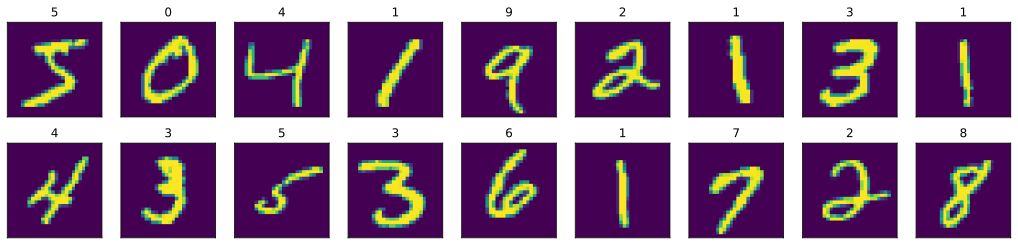

In [125]:
X,y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
# X.shape (18,1,28,28)
show_images(X.reshape(18,28,28),2,9,titles=get_mnist_labels(y))

# 定义模型-ResNet

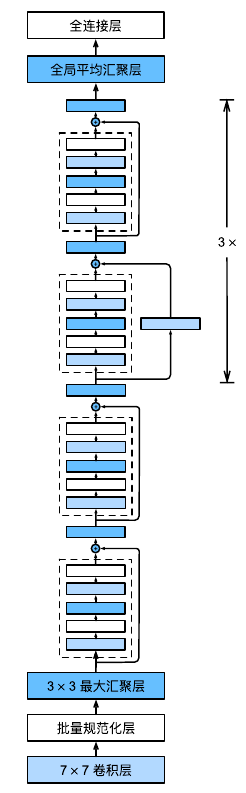

In [99]:
# 残差模块
class Residual(nn.Module):
  def __init__(self,input_channels, num_channels,
               use_1x1conv=False,strides=1):
    super().__init__()
    self.conv1 = nn.Conv2d(input_channels,num_channels,kernel_size=3,padding=1,stride=strides)
    self.conv2 = nn.Conv2d(num_channels,num_channels,kernel_size=3,padding=1)
    if use_1x1conv:
      # 把input_channels变成output_channels
      self.conv3 = nn.Conv2d(input_channels,num_channels,kernel_size=1,stride=strides)
    else:
      self.conv3 = None
    self.bn1 = nn.BatchNorm2d(num_channels)
    self.bn2 = nn.BatchNorm2d(num_channels)
  
  def forward(self,X):
    Y = F.relu(self.bn1(self.conv1(X)))
    Y = self.bn2(self.conv2(Y))
    if self.conv3:
      X = self.conv3(X)
    Y += X
    return F.relu(Y)

In [100]:

b1 = nn.Sequential(nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3),
                   nn.BatchNorm2d(64),nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3,stride=2,padding=1))

In [101]:
# ResNet由四个残差块组成，第一个模块的通道数与输入通道数相同，
# 之后的每个模块都在第一个残差块里将上一个模块的通道数翻倍，并将高宽减半
def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
  blk = []
  for i in range(num_residuals):
    if i == 0 and not first_block:
      blk.append(Residual(input_channels,num_channels,use_1x1conv=True,strides=2))
    else:
      blk.append(Residual(num_channels,num_channels))
  return blk

In [102]:
b2 = nn.Sequential(*resnet_block(64,64,2,first_block=True))
b3 = nn.Sequential(*resnet_block(64,128,2))
b4 = nn.Sequential(*resnet_block(128,256,2))
b5 = nn.Sequential(*resnet_block(256,512,2))
net = nn.Sequential(b1,b2,b3,b4,b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(),nn.Linear(512,10))

# 模型训练和评估

loss 0.001, train acc 1.000, test acc  0.992
cuda:0


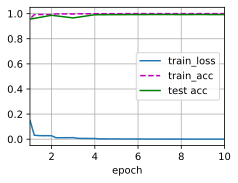

In [103]:
lr , num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = load_data_mnist(batch_size,resize=96)
train.train_GPU(net, train_iter, test_iter, num_epochs,lr, train.try_gpu(0))

# 预测

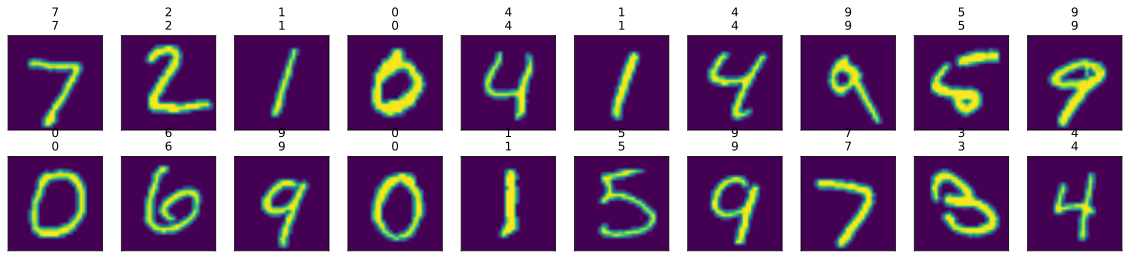

In [129]:
def predict(net, test_iter, n=6):
    for X,y in test_iter:
        X = X.to(train.try_gpu(0))
        y = y.to(train.try_gpu(0))
        break
    trues = get_mnist_labels(y)
    preds = get_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
     
    # print(X[0:n].shape)
    show_images(
        X[0:n].reshape(n,96,96),2,n//2,titles=titles[0:n]
    )
    
predict(net,test_iter,20)